# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(style='white', font_scale=1.0, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter


## Load and inventory

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from 
https://gssdataexplorer.norc.org/projects/48515

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [3]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [4]:
replace_invalid(gss)
gss.shape

(62466, 24)

In [5]:
def numnull(series):
    return sum(series.isnull())

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [6]:
numnull(gss.gunlaw)

21994

In [7]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [8]:
numnull(gss.owngun)

24826

In [9]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
numnull(gss.gun)

43138

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [12]:
numnull(gss.natcrime)

28064

In [13]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [14]:
varname = 'income'
numnull(gss[varname])

7961

In [15]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [16]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [17]:
varname = 'realinc'
numnull(gss[varname])

6325

In [18]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [19]:
varname = 'educ'
numnull(gss[varname])

174

In [20]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [21]:
varname = 'polviews'
numnull(gss[varname])

9385

In [22]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [23]:
numnull(gss.age)

221

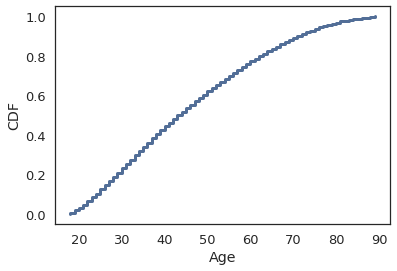

In [24]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [25]:
numnull(gss.cohort)

221

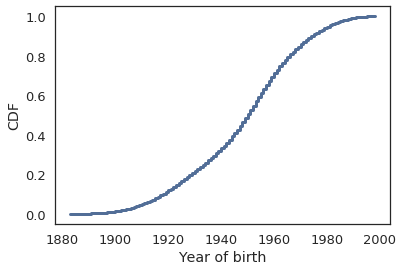

In [26]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [27]:
numnull(gss.sex)

0

In [28]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [29]:
numnull(gss.race)

0

In [30]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [31]:
numnull(gss.hispanic)

38149

In [32]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [33]:
numnull(gss.srcbelt)

0

In [34]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

## Remove rows missing key variables

In [35]:
gss.shape

(62466, 24)

In [36]:
gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
gss.shape

(40339, 24)

### Fill missing values

In [37]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    #print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [38]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    #print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [39]:
def fill_all_missing(df):
    varnames = ['owngun', 'gun', 'natcrime',
                'income', 'realinc', 'educ', 'polviews',
                'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
        
    # filling age is special because we have to fill cohort
    # to be consistent
    # but for generational analysis, we shouldn't fill age;
    # it just messes things up
    # fill_age(df)

In [40]:
fill_all_missing(gss)

### Make age and cohort groups

In [41]:
def make_groups(gss):
    gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5    
    gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
    gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
    gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
    gss['year8'] = utils.RoundIntoBins(gss, 'year', 8)
    gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
    gss['age10'] = utils.RoundIntoBins(gss, 'age', 10) + 5
    gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
    gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5

In [42]:
make_groups(gss)

Group people into 5- and 10-year bins by birth year.

In [43]:
# count cases where we have the dependent var
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     226
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [44]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     226
Name: gunlaw, dtype: int64

In [45]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     392
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [46]:
utils.values(gss, 'year')

1972    1559
1973    1467
1974    1453
1975    1445
1976    1467
1977    1492
1980    1430
1982    1804
1984    1424
1985    1504
1987    1769
1988     944
1989    1012
1990     898
1991     975
1993    1051
1994    1953
1996    1878
1998    1835
2000    1807
2002     913
2004     889
2006    1958
2008    1329
2010    1269
2012    1278
2014    1686
2016    1850
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [47]:
utils.values(gss, 'year4')

1971    3026
1975    5857
1979    1430
1983    4732
1987    3725
1991    2924
1995    3831
1999    3642
2003    1802
2007    3287
2011    2547
2015    3536
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [48]:
utils.values(gss, 'age5')

17.5     701
22.5    3595
27.5    4367
32.5    4332
37.5    4135
42.5    3779
47.5    3459
52.5    3211
57.5    2949
62.5    2672
67.5    2397
72.5    1903
77.5    1412
82.5     829
87.5     598
Name: age5, dtype: int64

In [49]:
utils.values(gss, 'age3')

19.5    1312
22.5    2202
25.5    2488
28.5    2661
31.5    2632
34.5    2534
37.5    2544
40.5    2304
43.5    2232
46.5    2062
49.5    2054
52.5    1955
55.5    1793
58.5    1755
61.5    1663
64.5    1520
67.5    1437
70.5    1276
73.5    1076
76.5     920
79.5     698
82.5     494
85.5     358
88.5     369
Name: age3, dtype: int64

### Make booleans

In [50]:
def copy_nan(df, varname, newvar):
    """Put a NaN into newvar in any place where varname is Nan.
    
    df: DataFrame
    varname: string old var name
    newvar: string new var name
    """
    df.loc[df[varname].isnull(), newvar] = np.nan

In [51]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [52]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    quantile25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= quantile25 
    copy_nan(df, 'realinc', 'lowrealinc')

    quantile75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= quantile75 
    copy_nan(df, 'realinc', 'highrealinc')

In [53]:
make_booleans(gss)

### Center cohort, age, and year.

In [54]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [55]:
center_factors(gss)

In [56]:
for varname in ['c', 'a', 'y']:
    print(varname, gss[varname].mean())

c -19.715089615508564
a -1.1577133791120255
y 2.1271970053794096


### Resample

Divide the sample up by year; resample within each year, using sampling weights; then concatenate the annual samples.

In [57]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(40339, 67)

In [58]:
utils.values(sample, 'twenties')

0.0    36190
1.0     4149
Name: twenties, dtype: int64

In [59]:
utils.values(sample, 'thirties')

0.0    35601
1.0     4738
Name: thirties, dtype: int64

In [60]:
utils.values(sample, 'forties')

0.0    33483
1.0     6856
Name: forties, dtype: int64

In [61]:
utils.values(sample, 'fifties')

0.0    31974
1.0     8365
Name: fifties, dtype: int64

In [62]:
utils.values(sample, 'sixties')

0.0    34387
1.0     5952
Name: sixties, dtype: int64

In [63]:
utils.values(sample, 'seventies')

0.0    36884
1.0     3455
Name: seventies, dtype: int64

In [64]:
utils.values(sample, 'eighties')

0.0    38484
1.0     1855
Name: eighties, dtype: int64

In [65]:
utils.values(sample, 'nineties')

0.0    39798
1.0      541
Name: nineties, dtype: int64

In [66]:
utils.values(sample, 'favor')

0.0     9394
1.0    30945
Name: favor, dtype: int64

In [67]:
utils.values(sample, 'gunhome')

0.0    23252
1.0    17087
Name: gunhome, dtype: int64

In [68]:
utils.values(sample, 'threatened')

0.0    32599
1.0     7740
Name: threatened, dtype: int64

In [69]:
utils.values(sample, 'spendcrime')

0.0    12734
1.0    27605
Name: spendcrime, dtype: int64

In [70]:
utils.values(sample, 'topincome')

0.0    19811
1.0    20528
Name: topincome, dtype: int64

In [71]:
utils.values(sample, 'lowincome')

0.0    33031
1.0     7308
Name: lowincome, dtype: int64

In [72]:
utils.values(sample, 'lowrealinc')

0.0    31708
1.0     8631
Name: lowrealinc, dtype: int64

In [73]:
utils.values(sample, 'highrealinc')

0.0    28805
1.0    11534
Name: highrealinc, dtype: int64

In [74]:
utils.values(sample, 'liberal')

0.0    29245
1.0    11094
Name: liberal, dtype: int64

In [75]:
utils.values(sample, 'moderate')

0.0    24674
1.0    15665
Name: moderate, dtype: int64

In [76]:
utils.values(sample, 'conservative')

0.0    33166
1.0     7173
Name: conservative, dtype: int64

In [77]:
utils.values(sample, 'female')

0.0    18518
1.0    21821
Name: female, dtype: int64

In [78]:
utils.values(sample, 'ishisp')

0.0    37348
1.0     2991
Name: ishisp, dtype: int64

In [79]:
utils.values(sample, 'black')

0.0    34686
1.0     5653
Name: black, dtype: int64

In [80]:
utils.values(sample, 'otherrace')

0.0    38142
1.0     2197
Name: otherrace, dtype: int64

In [81]:
utils.values(sample, 'urban')

0.0    15838
1.0    24501
Name: urban, dtype: int64

In [82]:
utils.values(sample, 'suburban')

0.0    29740
1.0    10599
Name: suburban, dtype: int64

In [83]:
utils.values(sample, 'rural')

0.0    35100
1.0     5239
Name: rural, dtype: int64

In [84]:
utils.values(sample, 'college')

0.0    22189
1.0    18150
Name: college, dtype: int64

## Create the resampled datasets

In [85]:
gss = utils.ReadGss('gss_gun')
replace_invalid(gss)
gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
gss.shape

(40339, 24)

In [86]:
def run_resampling(iters=101):
    """Run the resampling process and save the results.
    
    iters: number of times to run
    """
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
    
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_groups(sample)
        make_booleans(sample)
        center_factors(sample)

        key = 'iter%d' % i
        #print('Writing', key)
        sample.to_hdf('iterations.h5', key)

In [87]:
%time run_resampling()

CPU times: user 1min 53s, sys: 1min 20s, total: 3min 13s
Wall time: 50.7 s
